In [1]:
import numpy as np
import copy
from astropy.coordinates import Angle
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pyuvdata import UVData
import pyuvdata.utils as uvutils

In [2]:
file1 = '/data4/beards/phasing_test_data/1133866760.uvfits'
file2 = '/data4/beards/phasing_test_data/1133866760_rephase.uvfits'

In [3]:
uvd1 = UVData()
uvd2 = UVData()
uvd1.read_uvfits(file1)
uvd2.read_uvfits(file2)

In [4]:
uvd1_drift = copy.deepcopy(uvd1)
uvd1_drift.unphase_to_drift(phase_frame='gcrs', use_mwatools_phasing=False)
uvd1_drift_mwatools = copy.deepcopy(uvd1)
uvd1_drift_mwatools.unphase_to_drift(phase_frame='gcrs', use_mwatools_phasing=True)
uvd1_drift_antpos = copy.deepcopy(uvd1)
uvd1_drift_antpos.unphase_to_drift(phase_frame='gcrs', use_mwatools_phasing=True, use_ant_pos=True)
uvd2_drift = copy.deepcopy(uvd2)
uvd2_drift.unphase_to_drift(phase_frame='gcrs', use_mwatools_phasing=False)
uvd2_drift_mwatools = copy.deepcopy(uvd2)
uvd2_drift_mwatools.unphase_to_drift(phase_frame='gcrs', use_mwatools_phasing=True)
uvd2_drift_antpos = copy.deepcopy(uvd2)
uvd2_drift_antpos.unphase_to_drift(phase_frame='gcrs', use_mwatools_phasing=True, use_ant_pos=True)

In [5]:
data_diff_drift = uvd1_drift.data_array - uvd2_drift.data_array
print('Max absolute visibility difference after unphasing')
print(np.max(np.abs(data_diff_drift)))

Max absolute visibility difference after unphasing
1.2953553


In [6]:
uvw_diff_drift = uvd1_drift.uvw_array - uvd2_drift.uvw_array
print('Max absolute uvw difference after unphasing')
print(np.max(np.abs(uvw_diff_drift)))

Max absolute uvw difference after unphasing
0.08905029


In [7]:
print(uvd1.phase_center_ra, uvd1.phase_center_dec, uvd1.phase_center_epoch)

(0.4319689898685966, -0.31328660073298215, 2000.0)


In [8]:
uvd2_rephase = copy.deepcopy(uvd2_drift)
uvd2_rephase.phase(uvd1.phase_center_ra,
                   uvd1.phase_center_dec,
                   uvd1.phase_center_epoch,
                   phase_frame='gcrs', use_mwatools_phasing=False)
uvd2_rephase_mwatools = copy.deepcopy(uvd2_drift_mwatools)
uvd2_rephase_mwatools.phase(uvd1.phase_center_ra,
                            uvd1.phase_center_dec,
                            uvd1.phase_center_epoch,
                            phase_frame='gcrs', use_mwatools_phasing=True)
uvd2_rephase_antpos = copy.deepcopy(uvd2_drift_antpos)
uvd2_rephase_antpos.phase(uvd1.phase_center_ra,
                            uvd1.phase_center_dec,
                            uvd1.phase_center_epoch,
                            phase_frame='gcrs', use_mwatools_phasing=True, use_ant_pos=True)

In [9]:
data_diff = uvd1.data_array - uvd2_rephase.data_array
print('Max absolute visibility difference after phasing file2 to match file1 using simple phasing')
print(np.max(np.abs(data_diff)))

data_diff = uvd1.data_array - uvd2_rephase_mwatools.data_array
print('Max absolute visibility difference after phasing file2 to match file1 using mwatools phasing')
print(np.max(np.abs(data_diff)))

Max absolute visibility difference after phasing file2 to match file1 using simple phasing
1147.057
Max absolute visibility difference after phasing file2 to match file1 using mwatools phasing
1147.829


In [10]:
uvw_diff = uvd1.uvw_array - uvd2_rephase.uvw_array
print('Max absolute uvw difference after phasing file2 to match file1 using simple phasing')
print(np.max(np.abs(uvw_diff)))

uvw_diff = uvd1.uvw_array - uvd2_rephase_mwatools.uvw_array
print('Max absolute uvw difference after phasing file2 to match file1 using mwatools phasing')
print(np.max(np.abs(uvw_diff)))

Max absolute uvw difference after phasing file2 to match file1 using simple phasing
0.07611084
Max absolute uvw difference after phasing file2 to match file1 using mwatools phasing
0.076164246


In [11]:
def uvw_from_pos(uv_obj):
    if uv_obj.phase_type != 'drift':
        raise ValueError('uvw_from_pos can only be calculated for drift observations')
    
    antpos_ECEF = uv_obj.antenna_positions + uv_obj.telescope_location
    ant_pos_ENU = uvutils.ENU_from_ECEF(antpos_ECEF.T, *uv_obj.telescope_location_lat_lon_alt).T
    
    uvw_array = np.zeros_like(uv_obj.uvw_array)
    unique_bls, unique_inds = np.unique(uv_obj.baseline_array, return_index=True)
    for ind, bl in enumerate(unique_bls):
        inds = np.where(uv_obj.baseline_array == bl)[0]
        
        ant1_pos = ant_pos_ENU[uv_obj.ant_1_array[unique_inds[ind]]]
        ant2_pos = ant_pos_ENU[uv_obj.ant_2_array[unique_inds[ind]]]
        this_uvw = ant2_pos - ant1_pos
        
        uvw_array[inds, :] = this_uvw
    
    return uvw_array

In [12]:
ant_pos_diff = uvd1_drift.antenna_positions - uvd2_drift.antenna_positions
print(np.max(np.abs(ant_pos_diff)))
print(uvd1.antenna_names[0:4])
print(uvd1.antenna_numbers[0:4])
print(uvd1.antenna_positions[0:4, :])
antpos_ECEF = uvd1.antenna_positions + uvd1.telescope_location
antpos_ENU = uvutils.ENU_from_ECEF(antpos_ECEF.T, *uvd1.telescope_location_lat_lon_alt).T

print(antpos_ECEF[0:4, :])
print(antpos_ENU[0:4, :])

0.0
['Tile011', 'Tile012', 'Tile013', 'Tile014']
[0 1 2 3]
[[96.66319812 65.89844058 27.20527674]
 [47.04133089 43.44642706 30.98962764]
 [41.74838161 38.71622522 27.25628553]
 [34.51675652 31.24887885 20.48388862]]
[[-2559524.23682043  5095846.67363471 -2848988.72758185]
 [-2559573.85868766  5095824.22162118 -2848984.94323095]
 [-2559579.15163694  5095819.49141935 -2848988.67657305]
 [-2559586.38326204  5095812.02407298 -2848995.44896997]]
[[-115.95758419   31.26841622    1.62180192]
 [ -61.53756528   35.64225396    1.89569244]
 [ -54.68457944   31.47524262    1.91948901]
 [ -44.87059677   23.88522079    1.90115124]]


In [13]:
uvw_calc = uvw_from_pos(uvd1_drift)
uvw_diff_calc1 = uvd1_drift.uvw_array - uvw_calc
uvw_diff_calc2 = uvd2_drift.uvw_array - uvw_calc
uvw_ant_diff_calc1 = uvd1_drift_antpos.uvw_array - uvw_calc
uvw_ant_diff_calc2 = uvd2_drift_antpos.uvw_array - uvw_calc

In [14]:
print(np.max(np.abs(uvw_diff_calc1)))
print(np.max(np.abs(uvw_diff_calc2)))
print(np.max(np.abs(uvw_ant_diff_calc1)))
print(np.max(np.abs(uvw_ant_diff_calc2)))

0.11916947
0.08589158
0.0
0.0


In [15]:
def plot_uvw_diff(array1, array2, label1, label2):

    matplotlib.rcParams['figure.figsize'] = (20,20)

    diff_array = array1 - array2
    diff_label = label1 + " - " + label2
    
    plt.figure(1)
    fig, axes = plt.subplots(3, 3)
    axes[0, 0].scatter(array1[:,0], array2[:, 0],
                 s=0.25, marker="o")
    axes[0, 0].set_xlabel("u " + label1)
    axes[0, 0].set_ylabel("u " + label2)
    axes[0, 0].set_title("u")

    axes[0, 1].scatter(array1[:,1], array2[:, 1],
                 s=0.25, marker="o")
    axes[0, 1].set_xlabel("v " + label1)
    axes[0, 1].set_ylabel("v " + label2)
    axes[0, 1].set_title("v")

    axes[0, 2].scatter(array1[:,2], array2[:, 2],
                 s=0.25, marker="o")
    axes[0, 2].set_xlabel("w " + label1)
    axes[0, 2].set_ylabel("w " + label2)
    axes[0, 2].set_title("w: " + diff_label)

    axes[1, 0].scatter(array1[:,0], diff_array[:, 0],
                 s=0.25, marker="o")
    axes[1, 0].set_xlabel("u " + label1)
    axes[1, 0].set_ylabel("du (" + diff_label + ")")
    axes[1, 0].set_title("u: " + diff_label)

    axes[1, 1].scatter(array1[:,1], diff_array[:, 1],
                 s=0.25, marker="o")
    axes[1, 1].set_xlabel("v " + label1)
    axes[1, 1].set_ylabel("dv (" + diff_label + ")")
    axes[1, 1].set_title("v: " + diff_label)

    axes[1, 2].scatter(array1[:,2], diff_array[:, 2],
                 s=0.25, marker="o")
    axes[1, 2].set_xlabel("w " + label1)
    axes[1, 2].set_ylabel("dw (" + diff_label + ")")
    axes[1, 2].set_title("w: " + diff_label)

    axes[2, 0].scatter(np.linalg.norm(array1, axis=1),
                    np.linalg.norm(diff_array, axis=1),
                    s=0.25, marker="o")
    axes[2, 0].set_xlabel("|u" + label1 + "|")
    axes[2, 0].set_ylabel("|du| | (" + diff_label + ")|")
    axes[2, 0].set_title("|u|: " + diff_label)
    
#     axes[2, 1].scatter(np.linalg.norm(array1, axis=1),
#                     np.linalg.norm(diff_array/array1, axis=1),
#                     s=0.25, marker="o")
#     axes[2, 1].set_xlabel("|u" + label1 + "|")
#     axes[2, 1].set_ylabel("|du/u" + label1 + "| | (" + diff_label + ")|")
#     axes[2, 1].set_title("fractional |u|: " + diff_label)

    axes[2, 1].scatter(array1[:,0], array1[:, 1], s=0.25, marker="o")
    axes[2, 1].scatter(array2[:,0], array2[:, 1], s=0.25, marker="o", color='r')
    axes[2, 1].set_xlabel("u")
    axes[2, 1].set_ylabel("v")
    axes[2, 1].set_title("u vs v for both arrays")
    
    axes[2, 2].scatter(diff_array[:, 0], diff_array[:, 1], s=0.25, marker="o")
    axes[2, 2].set_xlabel("du (" + diff_label + ")")
    axes[2, 2].set_ylabel("dv (" + diff_label + ")")
    axes[2, 2].set_title("du vs dv (" + diff_label + ")")
     
    fig.show()

matplotlib is currently using a non-GUI backend, so cannot show the figure


<Figure size 1440x1440 with 0 Axes>

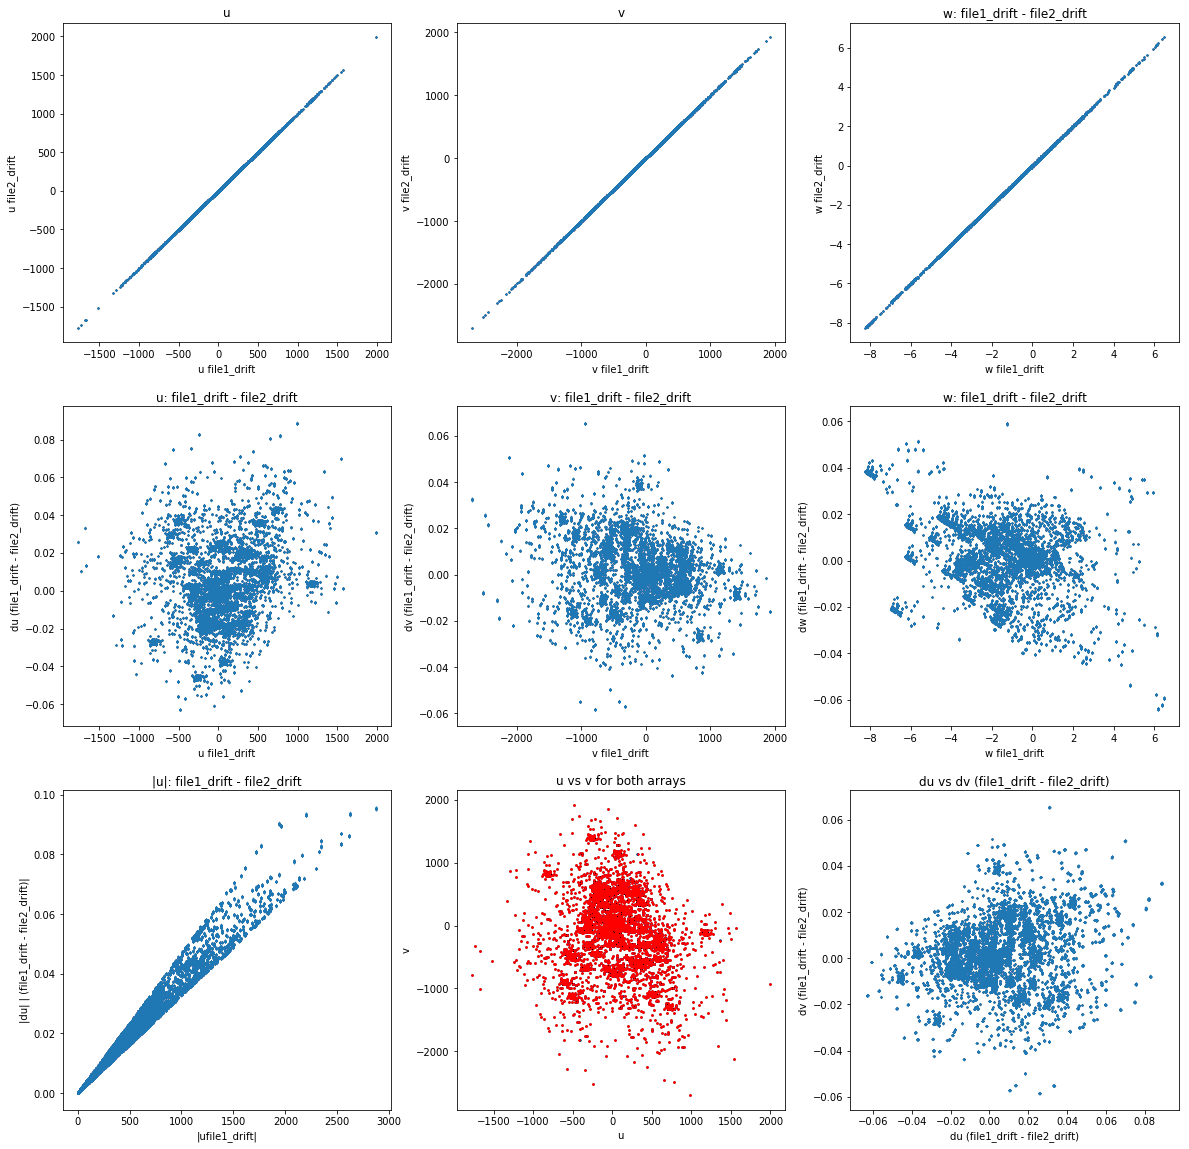

In [16]:
plot_uvw_diff(uvd1_drift.uvw_array, uvd2_drift.uvw_array, 'file1_drift', 'file2_drift')

<Figure size 1440x1440 with 0 Axes>

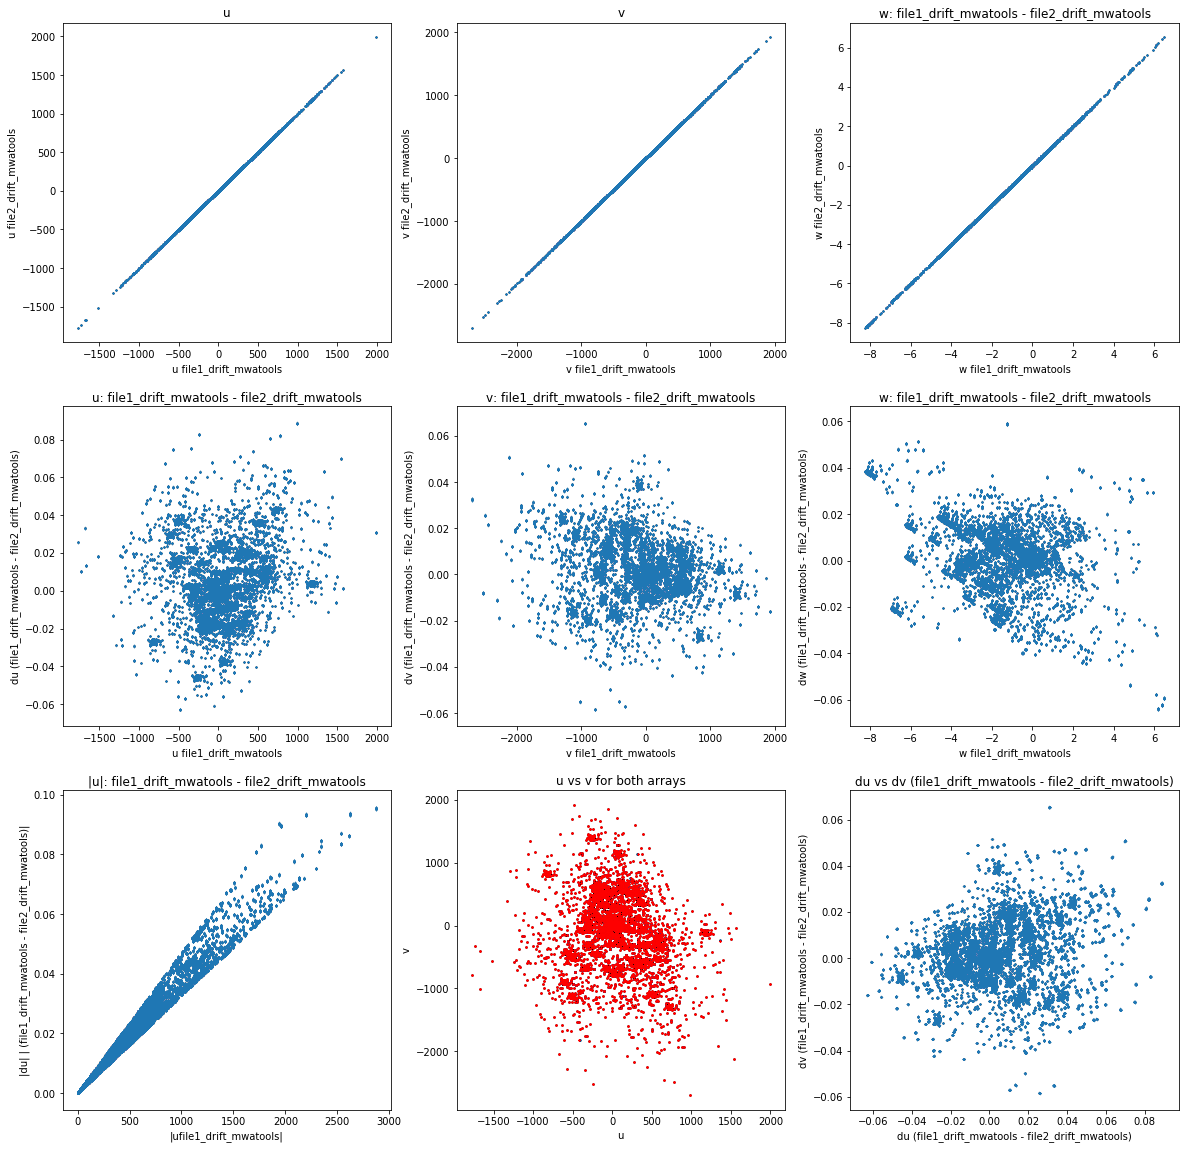

In [17]:
plot_uvw_diff(uvd1_drift_mwatools.uvw_array, uvd2_drift_mwatools.uvw_array, 'file1_drift_mwatools', 'file2_drift_mwatools')

<Figure size 1440x1440 with 0 Axes>

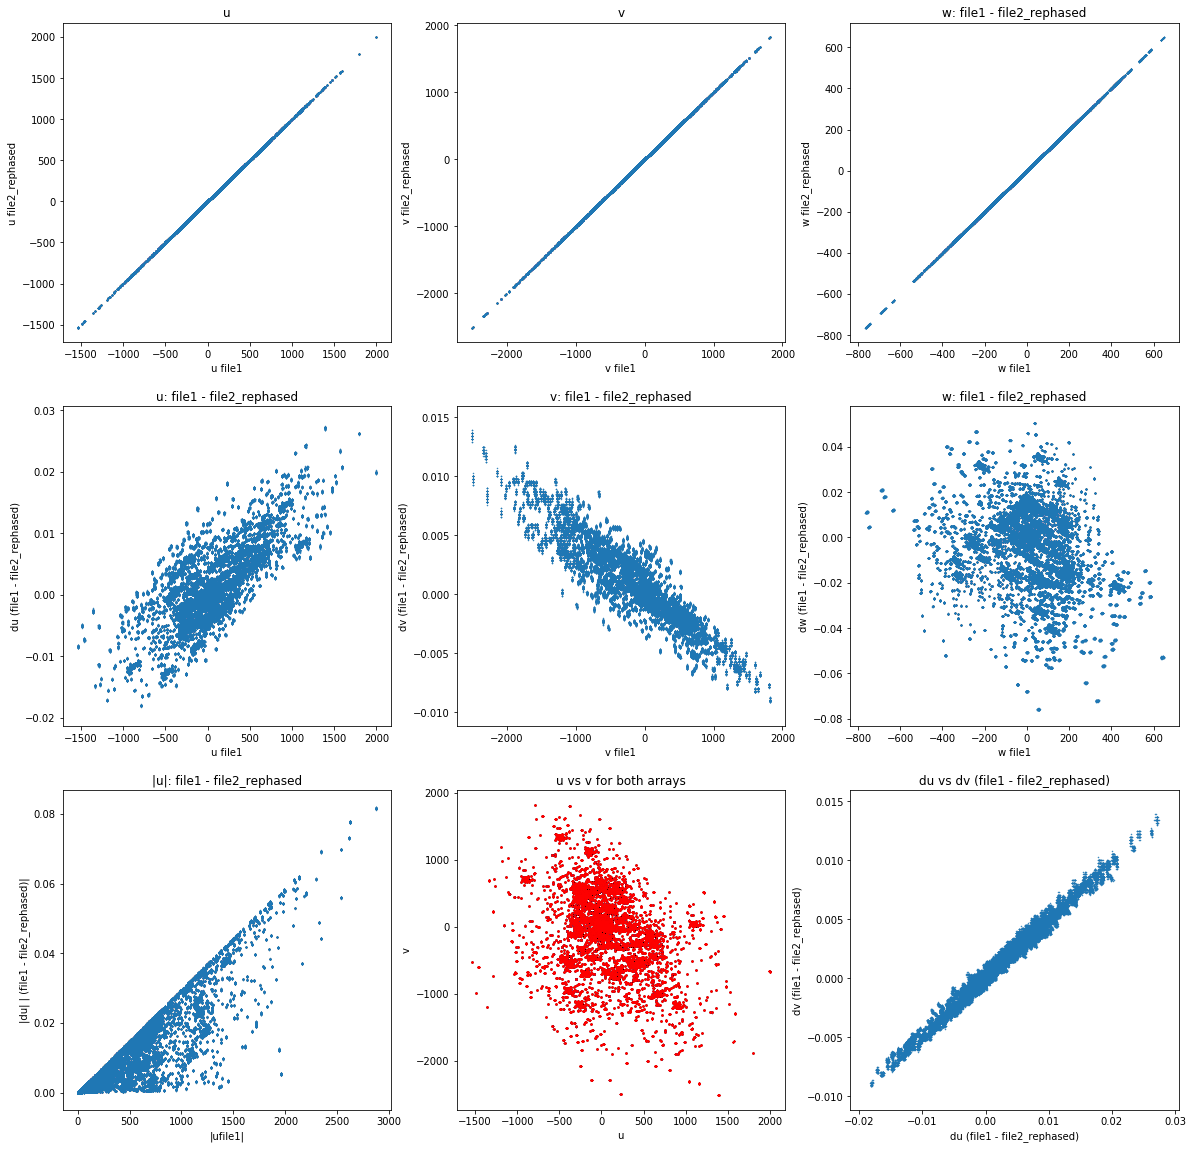

In [18]:
plot_uvw_diff(uvd1.uvw_array, uvd2_rephase.uvw_array, 'file1', 'file2_rephased')

<Figure size 1440x1440 with 0 Axes>

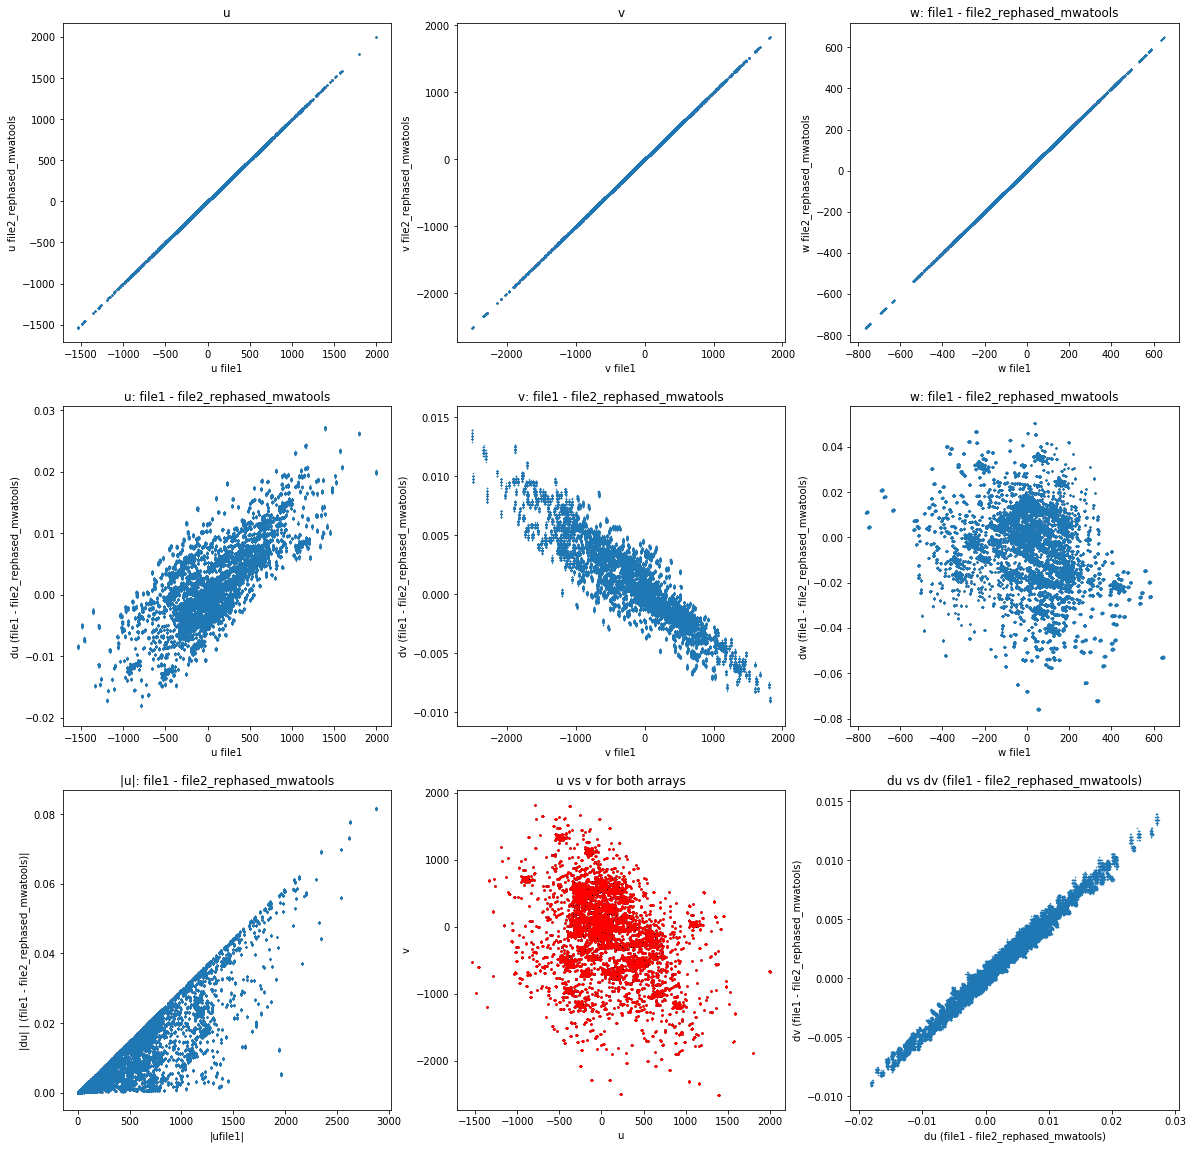

In [19]:
plot_uvw_diff(uvd1.uvw_array, uvd2_rephase_mwatools.uvw_array, 'file1', 'file2_rephased_mwatools')

<Figure size 1440x1440 with 0 Axes>

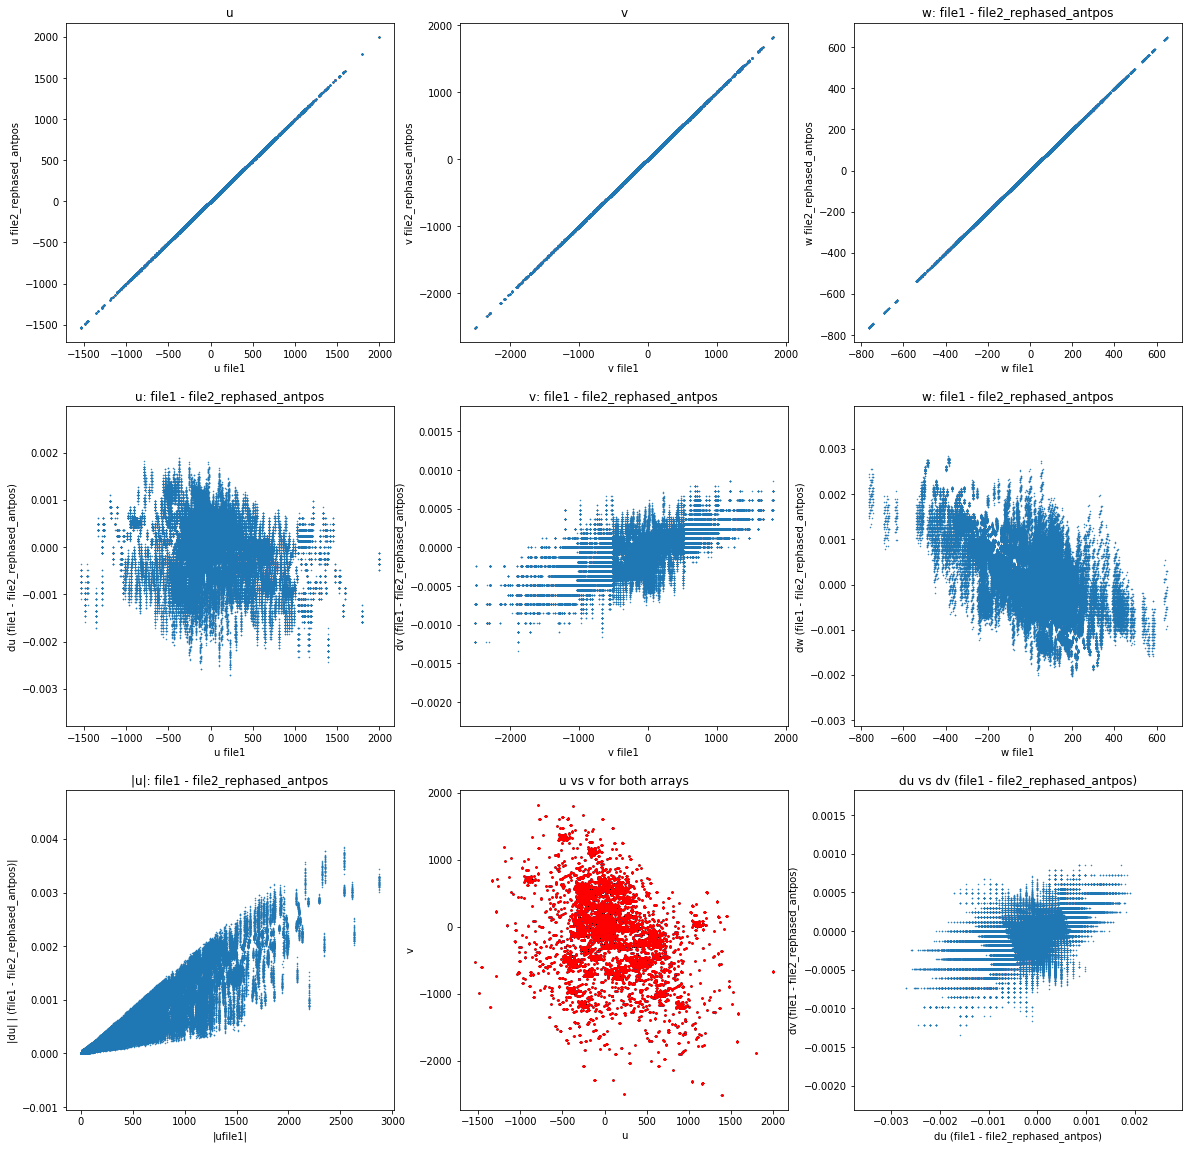

In [20]:
plot_uvw_diff(uvd1.uvw_array, uvd2_rephase_antpos.uvw_array, 'file1', 'file2_rephased_antpos')

<Figure size 1440x1440 with 0 Axes>

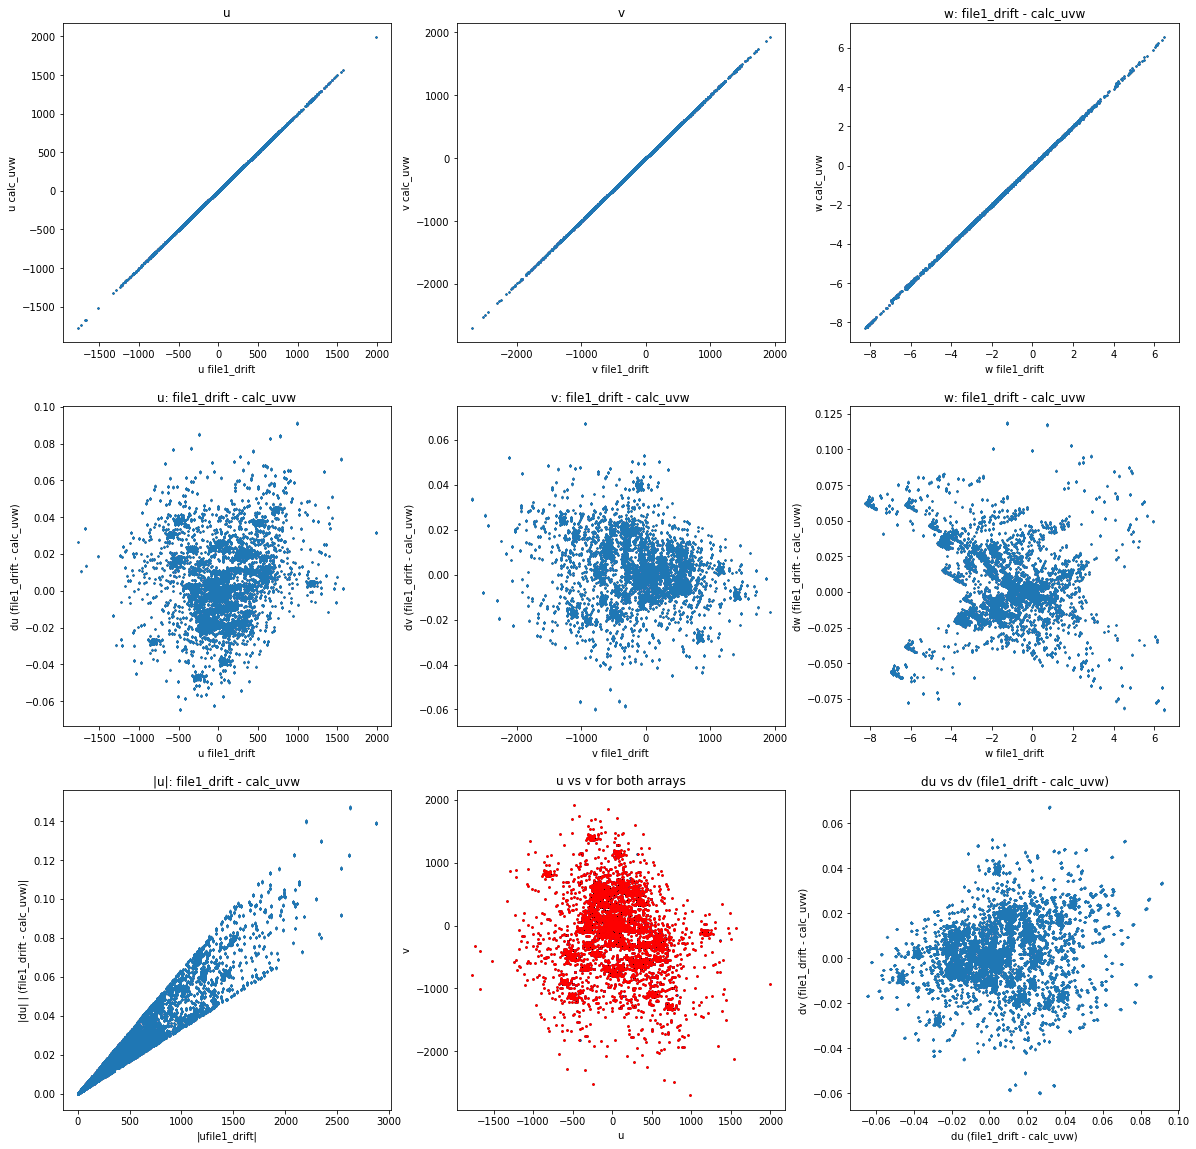

In [21]:
plot_uvw_diff(uvd1_drift.uvw_array, uvw_calc, 'file1_drift', 'calc_uvw')

<Figure size 1440x1440 with 0 Axes>

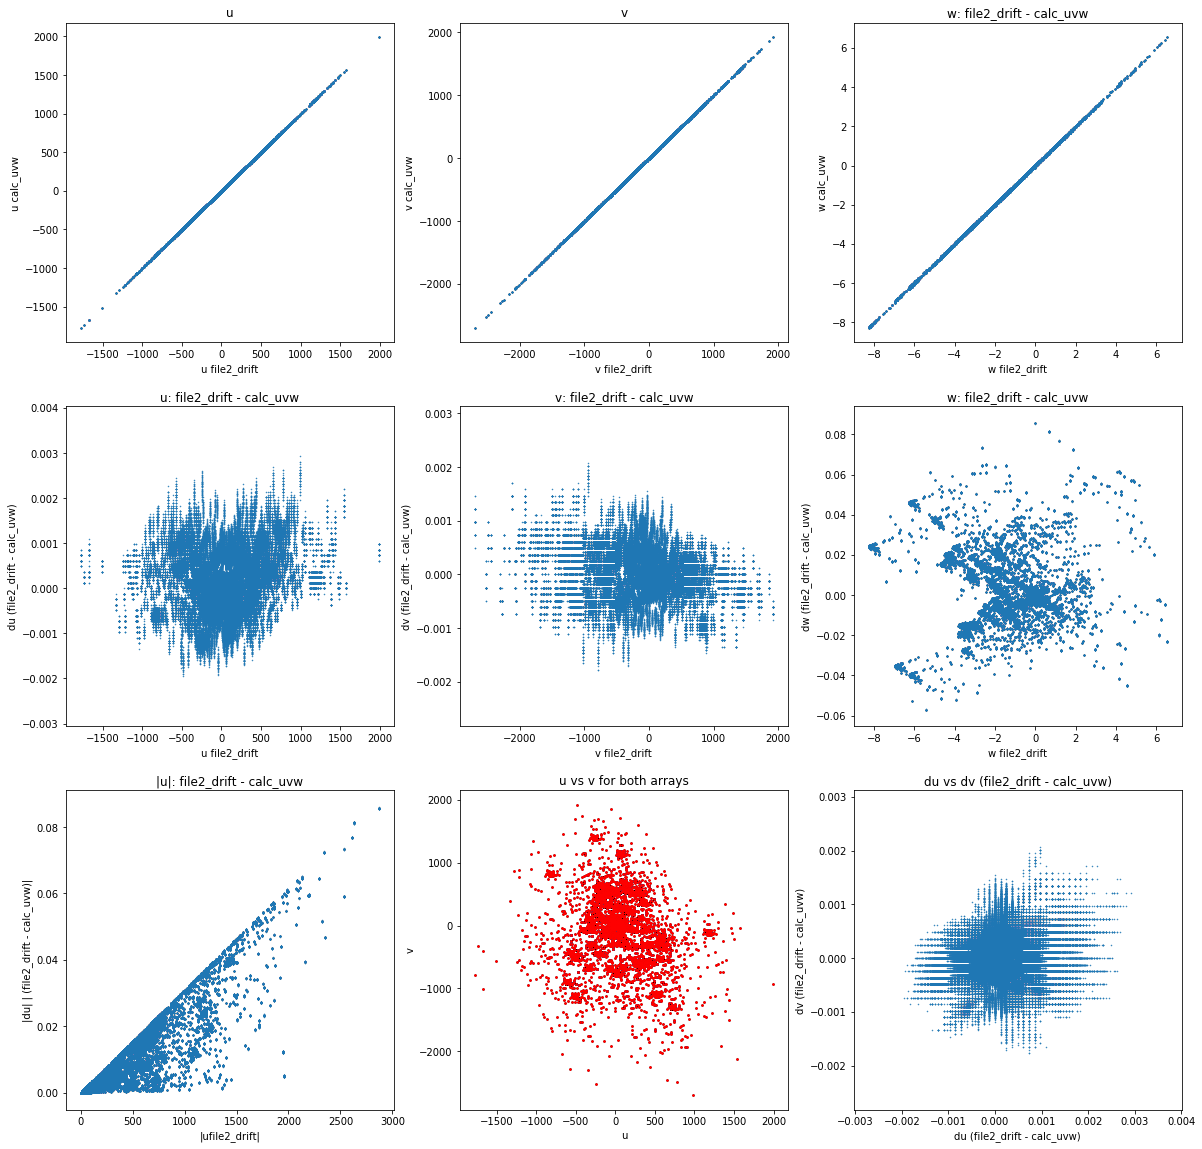

In [22]:
plot_uvw_diff(uvd2_drift.uvw_array, uvw_calc, 'file2_drift', 'calc_uvw')